In [1]:
!pip install -U seaborn keras-ncp

In [ ]:
pip install keras-ncp

In [7]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
#from kerasncp import wirings
#from kerasncp.tf import LTCCell
#import ltc_model as ltc
#from ctrnn_model import CTRNN, NODE, CTGRU
import argparse

training_files = [
    "a3_va3.csv",
    "b1_va3.csv",
    "b3_va3.csv",
    "c1_va3.csv",
    "c3_va3.csv",
    "a2_va3.csv",
    "a1_va3.csv",
]
def load_trace(filename):
    df = pd.read_csv(filename,header=0)
    
    str_y = df["Phase"].values
    convert = {"D":0,"P":1,"S":2,"H":3,"R":4}
    y = np.empty(str_y.shape[0],dtype=np.int32)
    for i in range(str_y.shape[0]):
        y[i] = convert[str_y[i]]
       
    x = df.values[:,:-1].astype(np.float32)
    
    return (x,y)

def cut_in_sequences(tup,seq_len,interleaved=False):
    x,y = tup

    num_sequences = x.shape[0]//seq_len
    sequences = []

    for s in range(num_sequences):
        start = seq_len*s
        end = start+seq_len
        sequences.append((x[start:end],y[start:end]))

        if(interleaved and s < num_sequences - 1):
            start += seq_len//2
            end = start+seq_len
            sequences.append((x[start:end],y[start:end]))

    return sequences

train_traces = []
valid_traces = []
test_traces = []

interleaved_train = True
for f in training_files:
    seq_len=32
    train_traces.extend(cut_in_sequences(load_trace(os.path.join("data/gesture",f)),seq_len,interleaved=interleaved_train))

    train_x,train_y = list(zip(*train_traces))

    train_x = np.stack(train_x,axis=1)
    train_y = np.stack(train_y,axis=1)


    flat_x = train_x.reshape([-1,train_x.shape[-1]])
    mean_x = np.mean(flat_x,axis=0)
    std_x = np.std(flat_x,axis=0)
    train_x = (train_x-mean_x)/std_x

    total_seqs = train_x.shape[1]
    print("Total number of training sequences: {}".format(total_seqs))
    permutation = np.random.RandomState(23489).permutation(total_seqs)
    valid_size = int(0.1*total_seqs)
    test_size = int(0.15*total_seqs)

    valid_x = train_x[:,permutation[:valid_size]]
    valid_y = train_y[:,permutation[:valid_size]]
    test_x = train_x[:,permutation[valid_size:valid_size+test_size]]
    test_y = train_y[:,permutation[valid_size:valid_size+test_size]]
    train_x = train_x[:,permutation[valid_size+test_size:]]
    train_y = train_y[:,permutation[valid_size+test_size:]]
    
    print("train_x.shape: ", str(train_x.shape))
    print("train_y.shape: ", str(train_y.shape))
    break

Total number of training sequences: 113
train_x.shape:  (32, 86, 32)
train_y.shape:  (32, 86)


In [ ]:
#pip install --upgrade tensorflow

In [10]:
from tensorflow import keras
from kerasncp import wirings
from kerasncp.tf import LTCCell
import matplotlib.pyplot as plt
import seaborn as sns

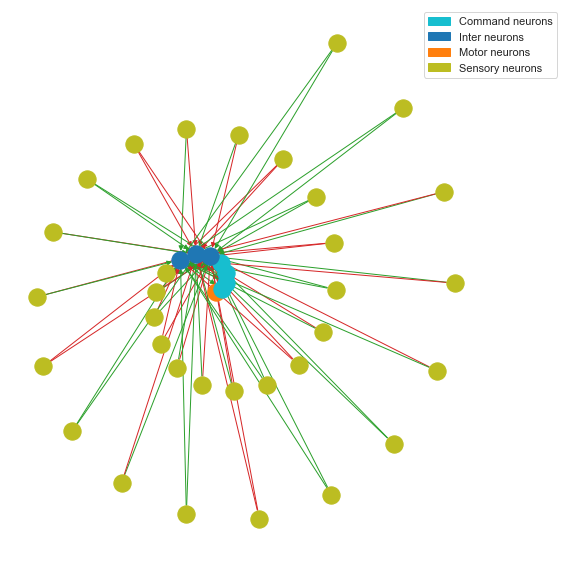

'\nsns.set_style("white")\nplt.figure(figsize=(8, 6))\nlegend_handles = ncp_cell.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})\nplt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))\nsns.despine(left=True, bottom=True)\nplt.tight_layout()\nplt.show()\n'

In [105]:
ncp_arch = wirings.NCP(
    inter_neurons=3,  # Number of inter neurons
    command_neurons=4,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=4,  # How many incomming syanpses has each motor neuron
)
ncp_cell = LTCCell(ncp_arch)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 32)),
        keras.layers.RNN(ncp_cell, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

sns.set_style("white")
plt.figure(figsize=(8, 8))
legend_handles = ncp_cell.draw_graph(layout='spiral',neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
'''
sns.set_style("white")
plt.figure(figsize=(8, 6))
legend_handles = ncp_cell.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
'''


In [106]:
keras.__version__

'2.4.0'

In [ ]:
hist_ncp = ncp_model.fit(x=train_x, y=train_y, batch_size=1, epochs=200,verbose=0)

In [ ]:
sns.set()
plt.figure(figsize=(6, 4))
plt.plot()
plt.plot(hist_ncp.history["loss"],label='ncp')
data_ltc_gesture = np.loadtxt('write_train_loss.txt')
x_ltc_gesture = data_ltc_gesture[:, 0]
y_ltc_gesture = data_ltc_gesture[:, 1]
plt.plot(x_ltc_gesture, y_ltc_gesture,'r',label="original-ltc")
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
ncp_model.evaluate(valid_x,valid_y)

In [ ]:
sparsity = 1 - ncp_cell.synapse_count /ltc_cell.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))